In [295]:
import pandas as pd
import numpy as np
#import shap
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, BaseCrossValidator
from sklearn.metrics import mean_absolute_error, mean_squared_error, max_error, accuracy_score, median_absolute_error, make_scorer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.early_stop import no_progress_loss
from hyperopt.pyll.base import Apply



import xgboost
import lightgbm
from scipy.stats import loguniform, randint, uniform
from scipy.spatial.distance import mahalanobis
import matplotlib.pyplot as plt
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from skopt.plots import plot_convergence
from hpsklearn import HyperoptEstimator, any_regressor, any_preprocessing
from hyperopt import tpe

def scorer(y_true, y_pred):
    """
    Scorer function where wrong predictions are penalized three times as much as correct predictions.
    """
    # Calculate whether the signs of the true and predicted values are different
    sign_diff = np.sign(y_true) != np.sign(y_pred)
    
    # Compute absolute errors
    abs_errors = np.abs(y_true - y_pred)
    
    # Double the error where the signs are different
    penalized_errors = abs_errors * (1 + sign_diff.astype(int))
    
    return penalized_errors.mean()

# Creating a custom scorer for use with sklearn
custom_scorer = make_scorer(scorer, greater_is_better=False)

Custom Time Series Cross-Validator -- Every year has a different number of races, so we can't use the regular time series CV

In [254]:
#Creating a custom time series cross-validator
class CustomTimeSeriesCV(BaseCrossValidator):
    """Creates an iterator that contains the indices from each dataset based on the years given"""
    def __init__(self, years):
        self.years = years

    def split(self, X, y=None, groups=None):
        for train_years, test_years in self.years:
            train_indices = np.where(X['year'].isin(train_years))[0]
            test_indices = np.where(X['year'].isin(test_years))[0]
            yield train_indices, test_indices
        
    def get_n_splits(self, X=None, y=None, groups=None):
        return len(self.years)

In [267]:
def custom_model(model, param_dict, X, y, iterations = 50):
   "Creating a custom CV to look through errors in a detailed manner"
   X_other, X_test, y_other, y_test = (X.loc[X['year'] < 2022, :], X.loc[X['year'] == 2022, :], 
                                    y.loc[X['year'] < 2022], y.loc[X['year'] == 2022])

   models = []
   test_scores = []
   for random_state in range(1, iterations):
      
      one_hot_fts = ['office_type', 'final_rating', 'open_seat']
      std_fts = ['midterm', 'incumbent_margin', 'covi_num','special', 'prev_gb_margin', 'prev2_gb_margin',
         'mean_specials_differential', 'pvi', 'previous_cci', 'current_cci',
         'previous_gas', 'current_gas',  'previous_unemployment',
         'current_unemployment', 'absenteeexcusereq', 'pollhours',
         'avgpollhours', 'maxpollhours', 'minpollhours', 'regdeadlines',
         'voteridlaws', 'novoterid', 'noallmailvote', 'noearlyvote',
         'nofelonreg', 'nofelonsregafterincar', 'nonstrictid', 'nonstrictphoto',
         'noonlineregistration', 'nopermanentabsentee', 'nopollplacereg', 'nopr',
         'nosamedayreg', 'nostateholiday', 'pr16', 'pr17', 'pr175', 'pr60',
         'pr90', 'strictid', 'strictphoto', 'house_chamber_margin',
         'senate_chamber_margin', 'change_cci', 'change_unemployment']
         
      preprocessor = ColumnTransformer([
      ('cat', OneHotEncoder(), one_hot_fts), 
      ('num', 'passthrough', std_fts)])
      
      parameters = {key: value.rvs(random_state=random_state) for key, value in param_dict.items()}
      model = model.set_params(**parameters)
      
      pipe = make_pipeline(preprocessor, model)
      models.append(pipe)
      
      folds = [(range(2002, 2006, 2), [2006, 2008]),
         (range(2002, 2010, 2), [2010, 2012]),
         (range(2002, 2014, 2), [2014, 2016]),
         (range(2002, 2018, 2), [2018, 2020])]
      fold_scores = []
      for train, test in folds:
            X_train, X_val = X_other.loc[X['year'].isin(train), :], X_other.loc[X['year'].isin(test), :]
            y_train, y_val = y_other[X_other['year'].isin(train)], y_other[X_other['year'].isin(test)]
            
            pipe.fit(X_train, y_train)
            y_pred = pipe.predict(X_val)
            fold_scores.append(median_absolute_error(y_val, y_pred))
            print(f'Mean absolute error for {train} is {mean_absolute_error(y_val, y_pred)}')
            print(f'Mean squared error for {train} is {mean_squared_error(y_val, y_pred)}')
            print(f'Max error for {train} is {max_error(y_val, y_pred)}')
            print(f'Median absolute error for {train} is {median_absolute_error(y_val, y_pred)}')
            print('---------------------------------------------------------')
      test_scores.append(np.mean(fold_scores))
      
   val_score = test_scores[np.argmin(test_scores)]
   best_model = models[np.argmin(test_scores)]
   best_model.fit(X_other, y_other)

   print(f"training score is {mean_absolute_error(y_other, best_model.predict(X_other))}")
   print(f"validation score is {val_score}")
   print(f"test_score is {mean_absolute_error(y_test, best_model.predict(X_test))}")
   return best_model, val_score   


In [266]:
data = pd.read_csv("../cleaned_data/Finalized Dataset.csv")
filtered_data = data.drop(columns = ['district']).assign(pvi = lambda x: x['pvi'] * 2, 
                                                         midterm = lambda x: x['year'] % 4 != 0)
X = filtered_data.drop(columns=['margin'])
y = filtered_data['margin']

param_dist_xgb = {
    'n_estimators': randint(10, 251),  # Discrete uniform distribution
    'max_depth': randint(3, 16),  # Discrete uniform distribution
    'learning_rate': uniform(0.001, 0.199),  # Continuous uniform distribution
    'subsample': uniform(0.3, 0.7),  # Continuous uniform distribution
    'colsample_bytree': uniform(0.3, 0.7),  # Continuous uniform distribution
    'min_child_weight': randint(5, 16),  # Discrete uniform distribution
    'gamma': uniform(0.01, 99.99),  # Continuous uniform distribution
    'reg_alpha': uniform(0.01, 99.99),  # Continuous uniform distribution
    'reg_lambda': uniform(0.01, 99.99)  # Continuous uniform distribution
}

xgb = xgboost.XGBRegressor(n_jobs = -1)
custom_model(xgb, param_dist_xgb, X, y, iterations = 300)

Mean absolute error for range(2002, 2006, 2) is 11.443307292722965
Mean squared error for range(2002, 2006, 2) is 223.03219519358709
Max error for range(2002, 2006, 2) is 60.1678623022047
Median absolute error for range(2002, 2006, 2) is 8.89815877931987
---------------------------------------------------------
Mean absolute error for range(2002, 2010, 2) is 11.014038978311978
Mean squared error for range(2002, 2010, 2) is 190.1691261711266
Max error for range(2002, 2010, 2) is 47.13290371786209
Median absolute error for range(2002, 2010, 2) is 9.624918214793341
---------------------------------------------------------
Mean absolute error for range(2002, 2014, 2) is 9.743115011708953
Mean squared error for range(2002, 2014, 2) is 154.25216399111324
Max error for range(2002, 2014, 2) is 57.32746740712016
Median absolute error for range(2002, 2014, 2) is 8.048933346285775
---------------------------------------------------------
Mean absolute error for range(2002, 2018, 2) is 6.582044714

(Pipeline(steps=[('columntransformer',
                  ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                   ['office_type',
                                                    'final_rating',
                                                    'open_seat']),
                                                  ('num', 'passthrough',
                                                   ['midterm',
                                                    'incumbent_margin',
                                                    'covi_num', 'special',
                                                    'prev_gb_margin',
                                                    'prev2_gb_margin',
                                                    'mean_specials_differential',
                                                    'pvi', 'previous_cci',
                                                    'current_cci',
                                    

In [256]:
def run_model(model, param_dict, X, y, iterations = 75):
    """Runs through a given model to get the best estimator of that model, as well as the train/test score values."""
    X_train, X_test, y_train, y_test = (X.loc[X['year'] < 2022, :], X.loc[X['year'] == 2022, :], 
                                        y.loc[X['year'] < 2022], y.loc[X['year'] == 2022])
    
    folds = [(range(2002, 2006, 2), [2006, 2008]),
        (range(2002, 2010, 2), [2010, 2012]),
        (range(2002, 2014, 2), [2014, 2016]),
        (range(2002, 2018, 2), [2018, 2020])]

    cv = CustomTimeSeriesCV(folds)
        
    one_hot_fts = ['office_type', 'final_rating', 'open_seat']
    std_fts = ['midterm', 'incumbent_margin', 'covi_num','special', 'prev_gb_margin', 'prev2_gb_margin',
       'mean_specials_differential', 'pvi', 'previous_cci', 'current_cci',
       'previous_gas', 'current_gas',  'previous_unemployment',
       'current_unemployment', 'absenteeexcusereq', 'pollhours',
       'avgpollhours', 'maxpollhours', 'minpollhours', 'regdeadlines',
       'voteridlaws', 'novoterid', 'noallmailvote', 'noearlyvote',
       'nofelonreg', 'nofelonsregafterincar', 'nonstrictid', 'nonstrictphoto',
       'noonlineregistration', 'nopermanentabsentee', 'nopollplacereg', 'nopr',
       'nosamedayreg', 'nostateholiday', 'pr16', 'pr17', 'pr175', 'pr60',
       'pr90', 'strictid', 'strictphoto', 'house_chamber_margin',
       'senate_chamber_margin', 'change_cci', 'change_unemployment']
        
    preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(), one_hot_fts), 
    ('num', 'passthrough', std_fts)])
    
    model_name = model.__class__.__name__
        
    param_dict = {f"{model_name.lower()}__{key}": value for key, value in param_dict.items()}
    
    pipe = make_pipeline(preprocessor, model)
    
    bayes = RandomizedSearchCV(pipe, param_dict, n_iter=iterations, scoring='neg_median_absolute_error', cv = cv, verbose = 1)
    #bayes = BayesSearchCV(pipe, param_dict, n_iter=iterations, scoring=custom_scorer, cv = cv, verbose = 1)
    
    np.int = int # bayes uses np.int, which is deprecated -- this removes the error!
    bayes.fit(X_train, y_train)
    
    #Code only used if I want to debug and see how good the model is doing
    train_score_mae = mean_absolute_error(y_train, bayes.predict(X_train))
    train_score_mse = mean_squared_error(y_train, bayes.predict(X_train))
    test_score_mae = mean_absolute_error(y_test, bayes.predict(X_test))
    test_score_med_ae = median_absolute_error(y_test, bayes.predict(X_test))
    pct_right = np.mean(np.sign(y_test) == np.sign(bayes.predict(X_test)))
    max_test_score = max_error(y_test, bayes.predict(X_test))

    print(f"Train MAE is {train_score_mae}, Train MSE is {train_score_mse}")
    print(f"Test MAE is {test_score_mae}, Test MedAE is {test_score_med_ae}")
    print(f"Maximum error is {max_test_score}")
    print(f"The pct of correct predictions is {pct_right}")
    print(f"Score of estimator on non-2022 data is {-1*bayes.best_score_}")
    
    return (bayes, train_score_mae, test_score_mae)

In [257]:
data = pd.read_csv("../cleaned_data/Finalized Dataset.csv")
filtered_data = data.drop(columns = ['district']).assign(pvi = lambda x: x['pvi'] * 2, 
                                                         midterm = lambda x: x['year'] % 4 != 0)
X = filtered_data.drop(columns=['margin'])
y = filtered_data['margin']

"""param_dict_xgb = {
    'n_estimators': Integer(10, 250),
    'max_depth': Integer(3, 15),  # Reduced from 15
    'learning_rate': Real(0.001, 0.2, prior = 'log-uniform'),  # Reduced upper limit
    'subsample': Real(0.3, 1, prior = 'uniform'),  # Decreased
    'colsample_bytree': Real(0.3, 1, prior = 'uniform'),  # Decreased
    'min_child_weight': Integer(5, 15),  # Increased lower limit
    'gamma': Real(0.01, 100, prior = 'log-uniform'),  # Regularization
    'reg_alpha': Real(0.01, 100, prior = 'log-uniform'),  # Regularization
    'reg_lambda': Real(0.01, 100, prior = 'log-uniform')  # Regularization
}"""


param_dist_xgb = {
    'n_estimators': randint(10, 251),  # Discrete uniform distribution
    'max_depth': randint(3, 16),  # Discrete uniform distribution
    'learning_rate': uniform(0.001, 0.199),  # Continuous uniform distribution
    'subsample': uniform(0.3, 0.7),  # Continuous uniform distribution
    'colsample_bytree': uniform(0.3, 0.7),  # Continuous uniform distribution
    'min_child_weight': randint(5, 16),  # Discrete uniform distribution
    'gamma': uniform(0.01, 99.99),  # Continuous uniform distribution
    'reg_alpha': uniform(0.01, 99.99),  # Continuous uniform distribution
    'reg_lambda': uniform(0.01, 99.99)  # Continuous uniform distribution
}

xgb = xgboost.XGBRegressor(n_jobs = -1)
(bayes_model, train_score, test_score) = run_model(xgb, param_dist_xgb, X, y, iterations = 50)


param_dict_gbr = {
    'loss': Categorical(['squared_error', 'absolute_error']), 
    'learning_rate': Real(0.01, 1, prior='log-uniform'), 
    'max_iter': Integer(10, 200), 
    'max_leaf_nodes': Integer(10, 100), 
    'max_depth': Integer(5, 100), 
    'min_samples_leaf': Integer(5, 100), 
    'l2_regularization': Real(0.001, 1000, prior='log-uniform'), 
    'interaction_cst': Categorical(['pairwise', 'no_interactions'])
}

gbr = HistGradientBoostingRegressor()


param_dict_gbm = {
    'boosting_type': Categorical(['dart']),  # Stick to traditional to reduce complexity.
    'max_depth': Integer(2, 6),  # Lower max depth to control overfitting.
    'num_leaves': Integer(2, 8),  # Lower number of leaves to control overfitting.
    'learning_rate': Real(0.01, 0.1, prior='log-uniform'),  # Lower learning rates can lead to better generalization.
    'min_data_in_leaf': Integer(20, 40),  # Increase to provide a more conservative approach.
    'min_sum_hessian_in_leaf': Real(0.001, 0.1),  # Increasing this value can help with overfitting.
    'n_estimators': Integer(100, 300),  # Reducing the upper limit to prevent overfitting.
    'subsample_for_bin': Integer(20000, 200000),  # Adjust based on your data size and feature.
    'class_weight': Categorical([None]),  # Unless you have imbalanced classes, stick to None.
    'min_split_gain': Real(0.1, 1.0),  # Increase the minimum gain to reduce complex tree structures.
    'min_child_weight': Real(0.01, 1),  # Increase to add more constraints on the tree.
    'min_child_samples': Integer(20, 50),  # Increase to ensure more samples inform each split.
    'subsample': Real(0.5, 0.8),  # Decrease to add more randomness and reduce overfitting.
    'subsample_freq': Integer(1, 10),  # Ensure subsampling happens more regularly.
    'colsample_bytree': Real(0.5, 0.8),  # Decrease to add more randomness and reduce overfitting.
    'reg_alpha': Real(0.1, 10, prior='log-uniform'),  # Increase L1 regularization.
    'reg_lambda': Real(0.1, 10, prior='log-uniform')  # Increase L2 regularization.
}


gbm = lightgbm.LGBMRegressor(n_jobs = -1)

#run_model(gbr, param_dict_gbr, X, y, iterations=75)
#run_model(gbm, param_dict_gbm, X, y, iterations=40)


Fitting 4 folds for each of 50 candidates, totalling 200 fits
Train MAE is 4.947835442945541, Train MSE is 49.251908424160355
Test MAE is 6.820283865911831, Test MedAE is 5.522969699239104
Maximum error is 25.350468935011072
The pct of correct predictions is 0.94
Score of estimator on non-2022 data is 9.97431184110659


In [264]:
bayes_model.cv_results_['split3_test_score']

array([ -7.35217964,  -6.72672527,  -7.03969187,  -6.92579622,
        -6.67498647,  -7.17859256,  -6.80537277,  -8.47698414,
        -6.92403397,  -7.11428447,  -6.56825854,  -6.48589322,
        -6.31798158,  -7.56387987,  -7.43757567,  -6.36870104,
        -7.32794158,  -7.83527137,  -6.90039002,  -6.51929802,
       -24.88451556,  -7.12722607,  -6.49041954,  -8.72732995,
        -6.67140891, -10.96683856, -20.54143044,  -6.77127147,
        -6.84036351,  -7.04357539,  -7.1345125 ,  -7.5210047 ,
        -7.39843885,  -6.76642438,  -7.16533738,  -7.03253943,
        -8.51433868,  -6.81587745,  -7.31061511,  -6.69304364,
        -7.29783043, -14.76909085,  -6.66130313,  -8.49394558,
        -6.9255986 ,  -7.35063311, -16.94218067,  -6.8314438 ,
        -7.37625872,  -6.70950968])

Testing HyperOpt

In [349]:
X_train, X_test, y_train, y_test = (X.loc[X['year'] < 2022, :], X.loc[X['year'] == 2022, :], 
                                    y.loc[X['year'] < 2022], y.loc[X['year'] == 2022])

# Assuming X_train includes the 'year' column
year_array = X_train['year']

# Create your fold structure
folds = [
    (range(2002, 2006, 2), [2006, 2008]),
    (range(2002, 2010, 2), [2010, 2012]),
    (range(2002, 2014, 2), [2014, 2016]),
    (range(2002, 2018, 2), [2018, 2020])
]

cv = CustomTimeSeriesCV(folds)
    
one_hot_fts = ['office_type', 'final_rating', 'open_seat']
std_fts = ['incumbent_margin', 'covi_num','special', 'prev_gb_margin', 'prev2_gb_margin',
    'mean_specials_differential', 'pvi', 'previous_cci', 'current_cci',
    'previous_gas', 'current_gas',  'previous_unemployment',
    'current_unemployment', 'absenteeexcusereq', 'pollhours',
    'avgpollhours', 'maxpollhours', 'minpollhours', 'regdeadlines',
    'voteridlaws', 'novoterid', 'noallmailvote', 'noearlyvote',
    'nofelonreg', 'nofelonsregafterincar', 'nonstrictid', 'nonstrictphoto',
    'noonlineregistration', 'nopermanentabsentee', 'nopollplacereg', 'nopr',
    'nosamedayreg', 'nostateholiday', 'pr16', 'pr17', 'pr175', 'pr60',
    'pr90', 'strictid', 'strictphoto', 'house_chamber_margin',
    'senate_chamber_margin', 'change_cci', 'change_unemployment']
    
preprocessor = ColumnTransformer([
('cat', OneHotEncoder(), one_hot_fts), 
('num', 'passthrough', std_fts)])

n_states = 50
preds_2022 = np.empty((len(y_test), n_states))

for random_state in range(0, n_states):
    def objective(params):
        clf = xgboost.XGBRegressor(**params, random_state = random_state, n_jobs=-1)
        pipe = make_pipeline(preprocessor, clf)

        cv_scores = []
        for train_idx, test_idx in cv.split(X_train):
            pipe.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
            predictions = pipe.predict(X_train.iloc[test_idx])
            max_year = X_train.iloc[test_idx]['year'].max()
            score = (max_year - 2002) / 16 * median_absolute_error(y_train.iloc[test_idx], predictions)
            cv_scores.append(score)

        print(cv_scores)
        avg_mae = np.mean(cv_scores)
        return {'loss': avg_mae, 'status': STATUS_OK}


    space = {
        'n_estimators': hp.randint('n_estimators', 10, 251),
        'max_depth': hp.randint('max_depth', 5, 10),
        'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.2)),
        'subsample': hp.uniform('subsample', 0.3, 1),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1),
        'min_child_weight': hp.randint('min_child_weight', 5, 10),
        'gamma': hp.loguniform('gamma', np.log(1), np.log(20)),
        'reg_alpha': hp.loguniform('reg_alpha', np.log(0.1), np.log(10)),
        'reg_lambda': hp.loguniform('reg_lambda', np.log(0.1), np.log(10))
    }


    trials = Trials()
    best_params = fmin(fn=objective,
                    space=space,
                    algo=tpe.suggest,
                    trials=trials, 
                    early_stop_fn=no_progress_loss(iteration_stop_count=5), 
                    rstate=np.random.Generator(np.random.PCG64(random_state)))

    print("Best parameters:", best_params)
    acc_xgb = xgboost.XGBRegressor(**best_params, n_jobs=-1)
    pipe = make_pipeline(preprocessor, acc_xgb)
    pipe.fit(X_train, y_train)
    predictions = pipe.predict(X_test)
    preds_2022[:, random_state] = predictions
    print("MeanAbsoluteError:", mean_absolute_error(y_test, predictions))
    print("MedianAbsoluteError:", median_absolute_error(y_test, predictions))

    print(acc_xgb)

[3.3738263284194354, 5.806470129551147, 7.098073030840569, 5.22507150376768]
[8.574764023986205, 13.454684030697736, 19.811477691601752, 22.384456645278757]                                  
[6.787710910836263, 10.497079325849569, 15.292217324135013, 16.01257704006327]                                   
[4.080475774682299, 7.0574021908973155, 9.453655613801873, 7.644597423499467]                                    
[9.02830492613805, 13.889753189547903, 20.208785769933627, 23.386077326991416]                                   
  0%|          | 5/9223372036854775807 [00:08<4491065194813849:36:00,  1.75s/trial, best loss: 5.375860248144708]
Best parameters: {'colsample_bytree': 0.4547867536333303, 'gamma': 6.644065921864898, 'learning_rate': 0.02202605484969771, 'max_depth': 7, 'min_child_weight': 9, 'n_estimators': 142, 'reg_alpha': 0.24043206714908386, 'reg_lambda': 0.2391480567734706, 'subsample': 0.7775845345223573}
MeanAbsoluteError: 8.436163973047599
MedianAbsoluteError: 6.91707164

(array([ 6., 10., 14.,  5.,  3.,  2.,  4.,  1.,  3.,  1.,  0.,  0.,  0.,
         0.,  1.]),
 array([ 4.90324421,  5.4325377 ,  5.96183118,  6.49112466,  7.02041815,
         7.54971163,  8.07900511,  8.6082986 ,  9.13759208,  9.66688557,
        10.19617905, 10.72547253, 11.25476602, 11.7840595 , 12.31335298,
        12.84264647]),
 <BarContainer object of 15 artists>)

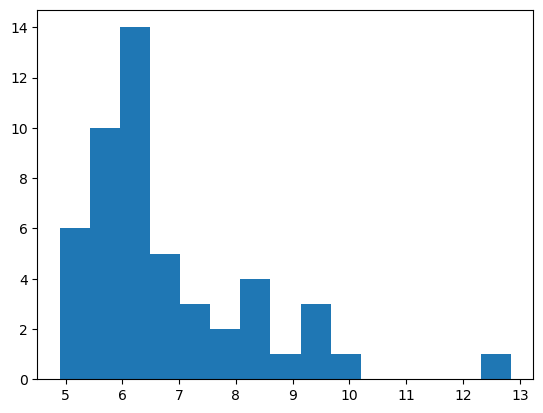

In [368]:
median_errors = []
for predictions in preds_2022.T:
    median_errors.append(median_absolute_error(y_test, predictions))
    
plt.hist(median_errors, bins = 15)

In [322]:
np.random.RandomState(3)


RandomState(MT19937) at 0x295CEC540